In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
import scipy as sp
from sklearn.linear_model import LinearRegression

In [ ]:
participant_data = pd.read_csv('/redacted/path/demographics.csv')
age = np.array(participant_data.age)
sex = np.array(participant_data.sex)
participantid = np.array(participant_data.ID)

In [ ]:
metrics = ['gyrification','thickness','curvature']
hemi = ['L','R']
metrichold = np.empty((7262,2,len(participantid),len(metrics)))

### Load in macrostructure surface files

In [ ]:
for ii in range(len(participantid)):
    for jj in range(len(hemi)):
        for kk in range(len(metrics)):
            if metrics[kk] == 'gyrification' or metrics[kk] == 'thickness' or metrics[kk] == 'curvature':
                metrichold[:,jj,ii,kk] = np.abs(nib.load(f'/redacted/path/sub-{participantid[ii]}_hemi-{hemi[jj]}_space-T1w_den-0p5mm_label-hipp_{metrics[kk]}.shape.gii').agg_data())

### For each subject, average within the subfields

In [ ]:
# Note that the subfield surface labels are the same across all participants

subholdL = nib.load(f'/redacted/path/sub-{participantid[ii]}_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-bigbrain_subfields.label.gii').agg_data()
subholdR = nib.load(f'/redacted/pathsub-{participantid[ii]}_hemi-R_space-T1w_den-0p5mm_label-hipp_atlas-bigbrain_subfields.label.gii').agg_data()

subfieldnum = [1,2,3,4,5]
subfieldlabel = ['Subiculum','CA1','CA2','CA3','DG/CA4']

metricsubfavg = np.empty((len(hemi),len(participantid),len(metrics),len(subfieldnum)))

for ii in range(len(subfieldnum)):
    subLind = subholdL == subfieldnum[ii]
    subRind = subholdR == subfieldnum[ii]

    metricsubfavg[0,:,:,ii] = np.mean(metrichold[subLind,0,:,:],axis=0)
    metricsubfavg[1,:,:,ii] = np.mean(metrichold[subRind,1,:,:],axis=0)

### Make averaged dataframe for plotting

In [ ]:
dL = {}
dR = {}
for ii in range(len(metrics)):
    dL[metrics[ii]] = metricsubfavg[0,:,ii,:].flatten(order='F')
    dR[metrics[ii]] = metricsubfavg[1,:,ii,:].flatten(order='F')


dL['age'] = np.tile(age,5)
dL['participantid'] = np.tile(participantid,5)
dL['sex'] = np.tile(sex,5)
dL['hemi'] = np.repeat(hemi[0],88*5)

dR['age'] = np.tile(age,5)
dR['participantid'] = np.tile(participantid,5)
dR['sex'] = np.tile(sex,5)
dR['hemi'] = np.repeat(hemi[1],88*5)

label = np.empty((88*5))
label[0:88] = 1
label[88:88*2] = 2
label[88*2:88*3] = 3
label[88*3:88*4] = 4
label[88*4:88*5] = 5
dL['subfield'] = label
dR['subfield'] = label

label = np.empty((88*5),dtype=object)
label[0:88] = 'subiculum'
label[88:88*2] = 'CA1'
label[88*2:88*3] = 'CA2'
label[88*3:88*4] = 'CA3'
label[88*4:88*5] = 'DG/CA4'
dL['subfield_labels'] = label
dR['subfield_labels'] = label

dfL = pd.DataFrame(data=dL)
dfR = pd.DataFrame(data=dR)

frames = [dfL, dfR]

dfcomb = pd.concat(frames)
dfcomb['curvature'] = np.abs(dfcomb['curvature'])

### Averaging hemispheres

In [ ]:
df = {}
for ii in range(len(metrics)):
    df[metrics[ii]] = np.mean(metricsubfavg[:,:,ii,:],axis=0).flatten(order='F')


df['age'] = np.tile(age,5)
df['participantid'] = np.tile(participantid,5)
df['sex'] = np.tile(sex,5)

label = np.empty((88*5))
label[0:88] = 1
label[88:88*2] = 2
label[88*2:88*3] = 3
label[88*3:88*4] = 4
label[88*4:88*5] = 5
df['subfield'] = label

label = np.empty((88*5),dtype=object)
label[0:88] = 'subiculum'
label[88:88*2] = 'CA1'
label[88*2:88*3] = 'CA2'
label[88*3:88*4] = 'CA3'
label[88*4:88*5] = 'DG/CA4'
df['subfield_labels'] = label

dfcomb = pd.DataFrame(data=df)

### This is the data in the dataset excel sheet provided with the manuscript

In [ ]:
dfplot = pd.melt(dfcomb,id_vars=['age','subfield','participantid','sex','subfield_labels'])

### Note curvature was not included in the main analysis

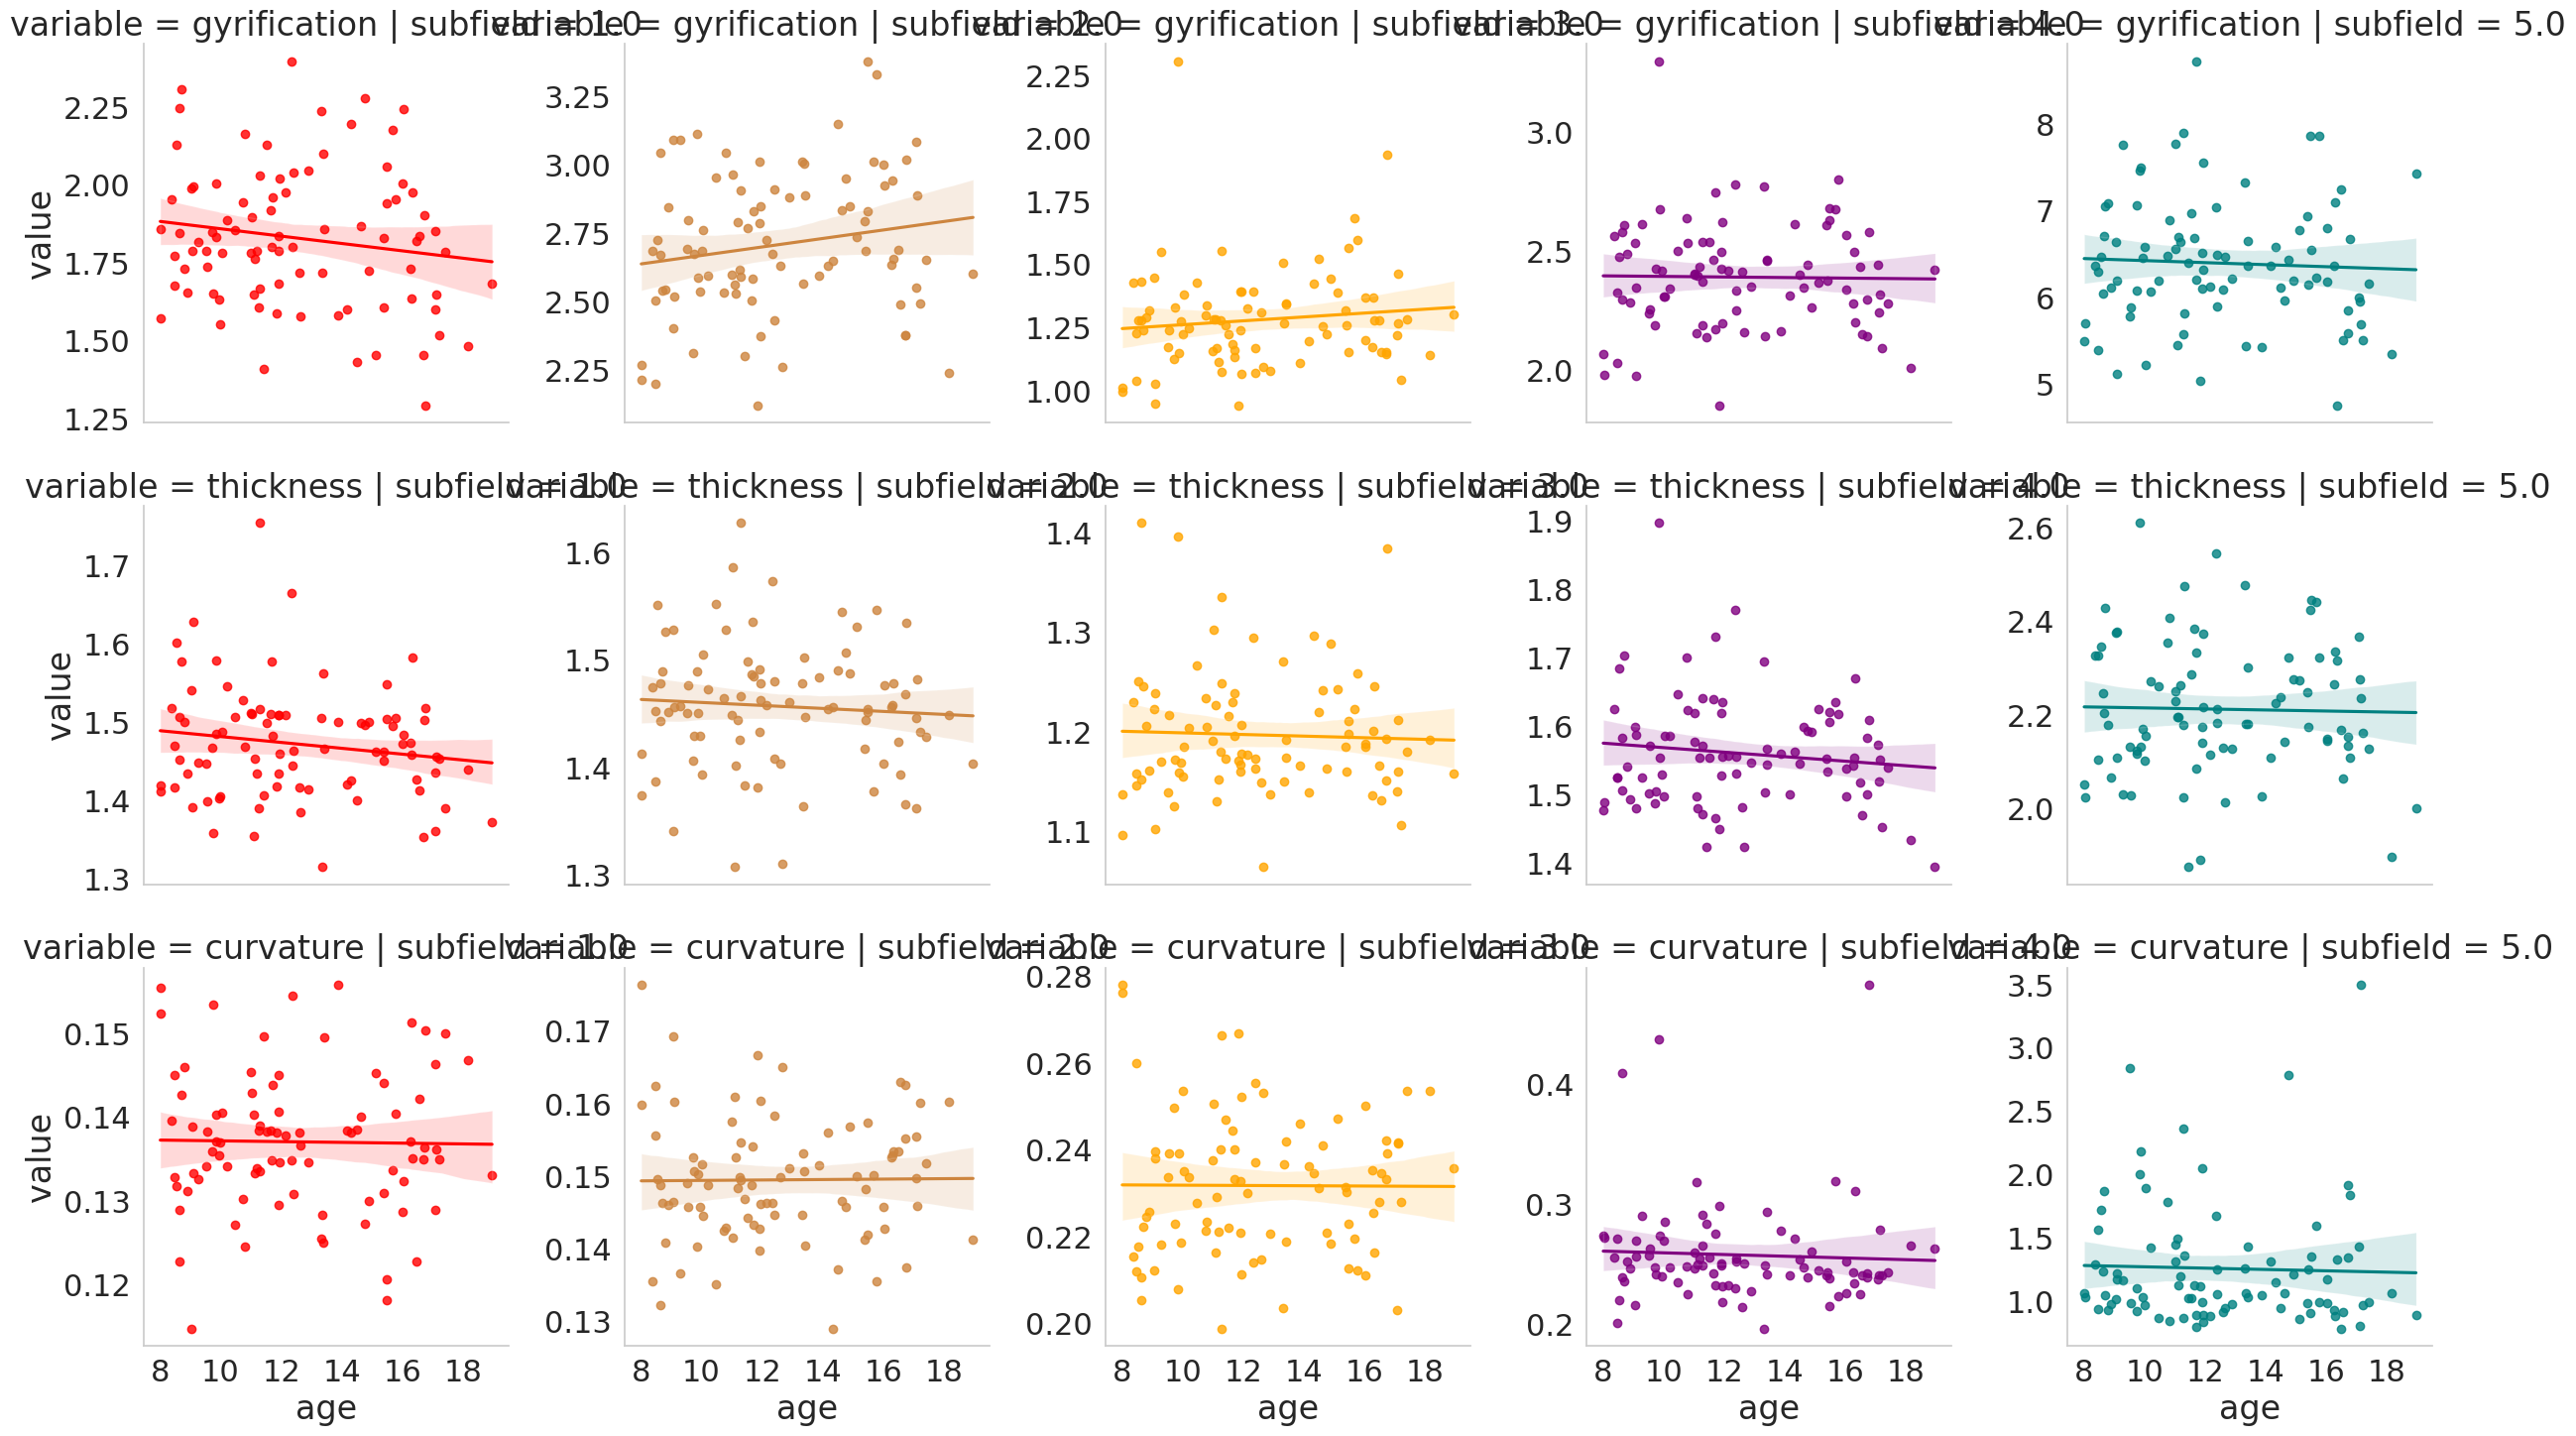

In [ ]:
flatui = ["red","peru", "orange","purple","teal"]
sns.set_palette(sns.color_palette(flatui))
palette=sns.color_palette(flatui)

sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})

lm = sns.lmplot(x="age", y='value', data=dfplot,row='variable',col='subfield',hue='subfield',palette=palette,order=1,facet_kws={'sharey': False,'sharex':True})
plt.xticks([8,10,12,14,16,18]) 

plt.show()

### Pearson's R within each subfield of age x metric

In [34]:
Rhold = np.empty((5,len(metrics)))
phold = np.empty((5,len(metrics)))

for ii in range(5):
    for jj in range(len(metrics)):
        Y = dfcomb[dfcomb['subfield']==ii+1][metrics[jj]]
        X = dfcomb[dfcomb['subfield']==ii+1]['age']
        #Rhold[ii,jj]= np.corrcoef(X,Y)[0,1]
        corr = sp.stats.pearsonr(X,Y)
        Rhold[ii,jj]= corr[0]
        phold[ii,jj]= corr[1]

<Axes: >

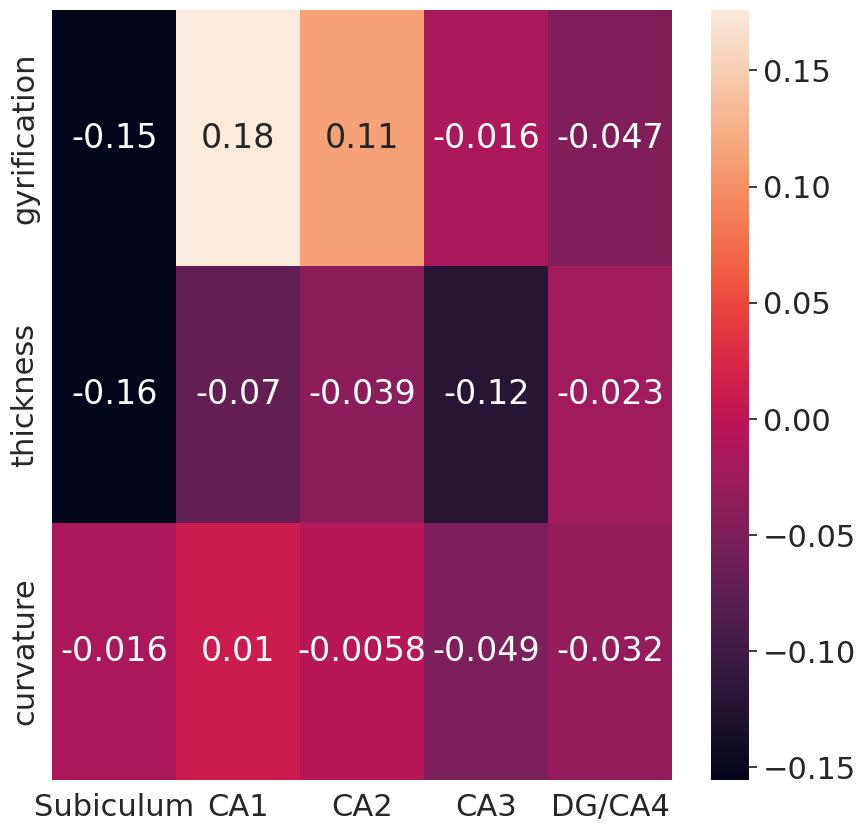

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

Rdf = pd.DataFrame(Rhold.T)
sns.heatmap(Rdf,annot=True,yticklabels=metrics,xticklabels=subfieldlabel)

### p-value of Pearson's R (is R sig. > 0)

<Axes: >

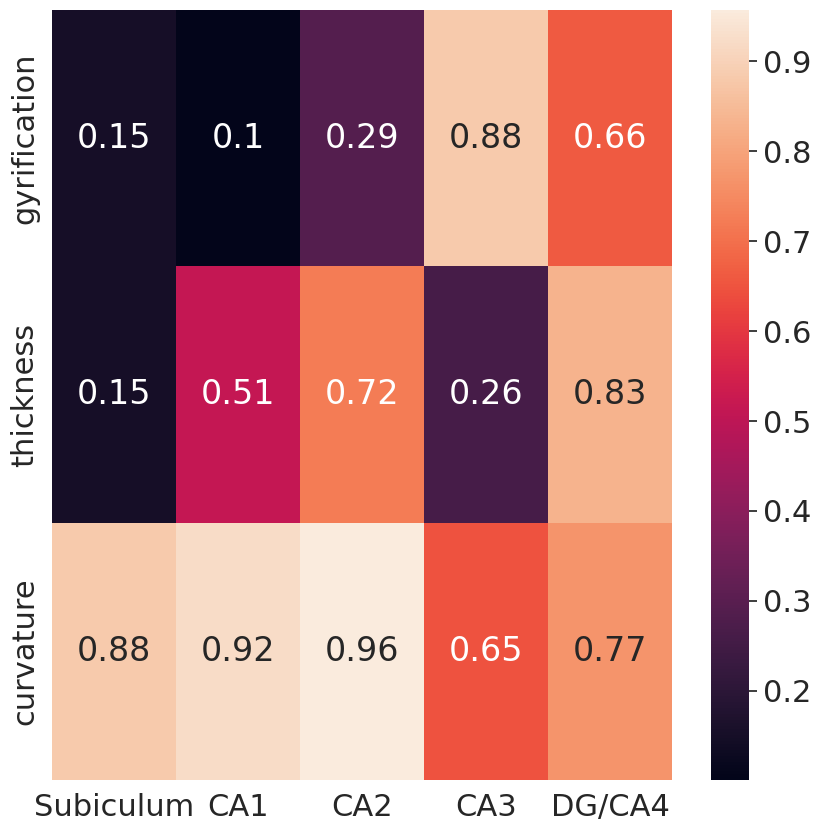

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

pval = pd.DataFrame(phold.T)
sns.heatmap(pval,annot=True,yticklabels=metrics,xticklabels=subfieldlabel)


# Sex analysis

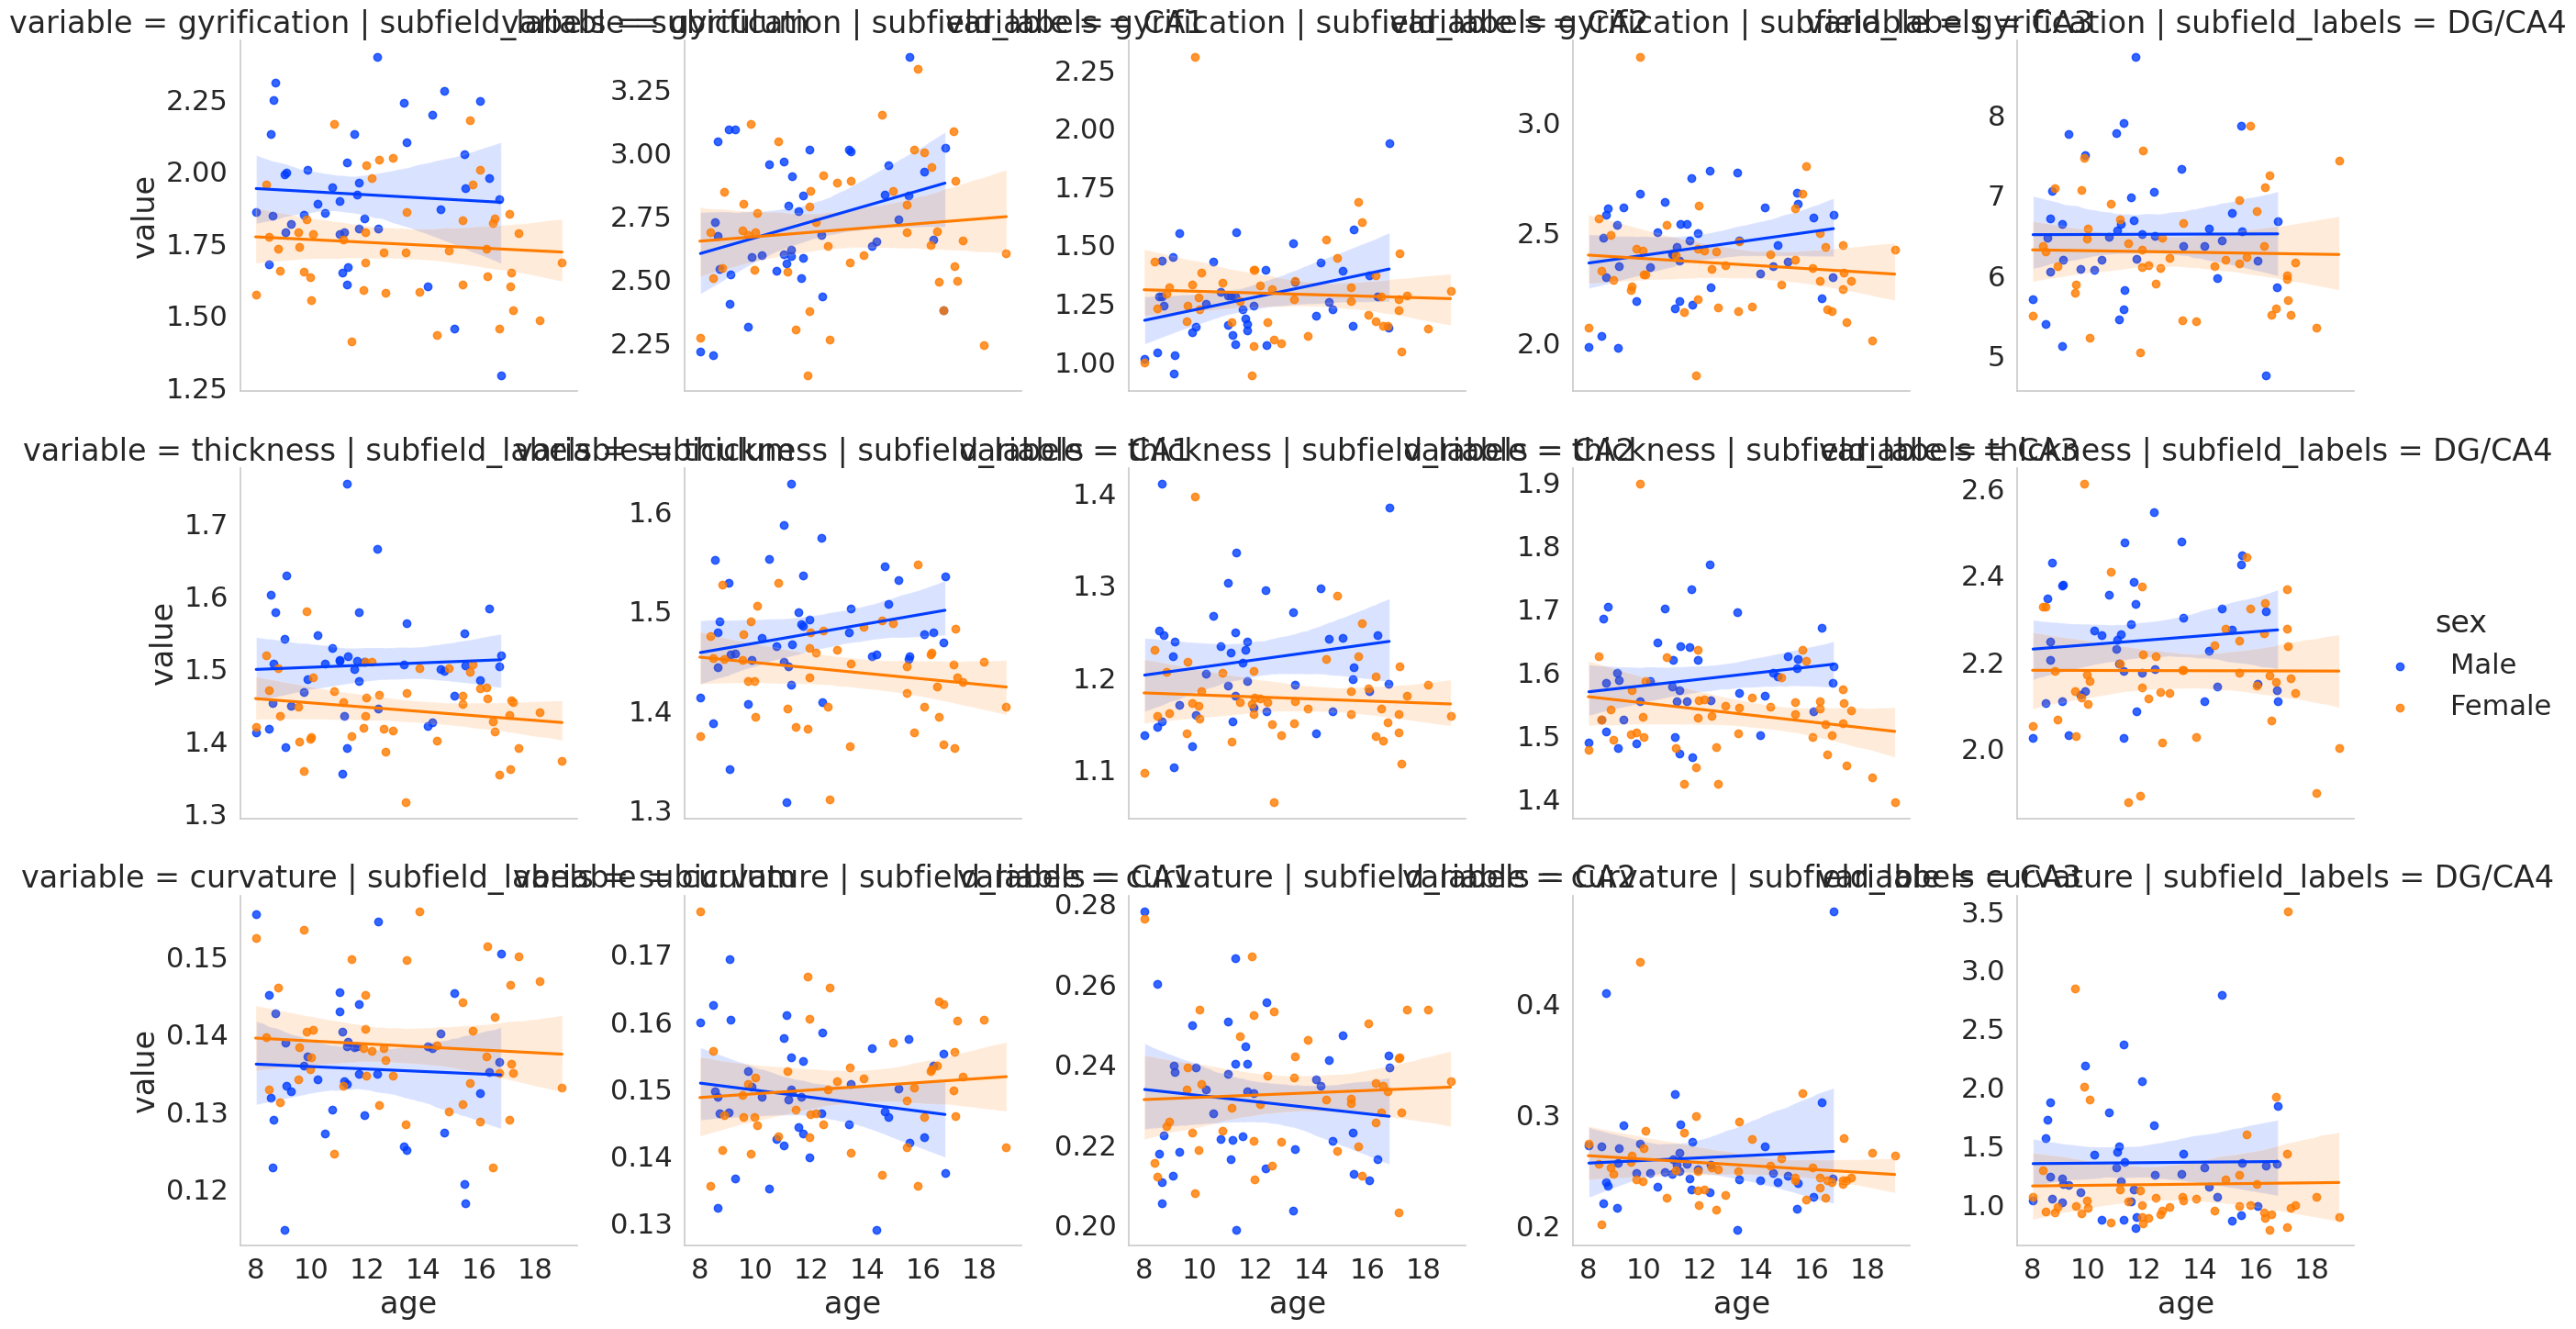

In [23]:
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})

lm = sns.lmplot(x="age", y='value', data=dfplot,row='variable',col='subfield_labels',hue='sex',palette='bright',order=1,facet_kws={'sharey': False,'sharex':True})
plt.xticks([8,10,12,14,16,18]) 
plt.show()

### Linear nested models for testing the significance of the age:sex interaction

In [14]:
lm3 = smf.ols(formula='gyrification ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='gyrification ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     425.0  62.695946      0.0       NaN       NaN       NaN
1     424.0  62.464218      1.0  0.231728  1.572944  0.210471


In [27]:
lm3 = smf.ols(formula='thickness ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm4 = smf.ols(formula='thickness ~ age + C(subfield_labels) + C(sex) + age:C(subfield_labels) + C(sex):C(subfield_labels) + age:C(sex)', data=dfcomb).fit()

anovaResults = anova_lm(lm3,lm4)
print(anovaResults)

   df_resid       ssr  df_diff  ss_diff        F    Pr(>F)
0     425.0  3.081787      0.0      NaN      NaN       NaN
1     424.0  3.046107      1.0  0.03568  4.96641  0.026368


### FDR correction of the above F-test p-values. Note that the p-value using subfield volumes is also included here, but that value was derived from the "volume_analysis.ipynb" notebook

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

print(fdrcorrection([0.014462,0.210471,0.026368]))

(array([ True, False,  True]), array([0.039552, 0.210471, 0.039552]))


### Linear nested models for testing the significance of the age:subfield interaction

In [ ]:
lm1 = smf.ols(formula='gyrification ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='gyrification ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  62.697961      0.0       NaN       NaN       NaN
1     424.0  62.464218      4.0  0.233743  0.396656  0.811057


In [ ]:
lm1 = smf.ols(formula='thickness ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels)', data=dfcomb).fit()
lm2 = smf.ols(formula='thickness ~ age + C(sex) + C(subfield_labels) + age:C(sex) + C(sex):C(subfield_labels) + age:(subfield_labels)', data=dfcomb).fit()

anovaResults = anova_lm(lm1,lm2)
print(anovaResults)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     428.0  3.051298      0.0       NaN       NaN       NaN
1     424.0  3.046107      4.0  0.005191  0.180628  0.948387
